In [1]:
import pandas as pd
import numpy as np
import os
import random
import torch
import pickle
import utilities
import preprocess
import similarities
import parameters
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations, product

from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

In [2]:
result_file_name = 'embedding_tuning_opp115-6.p'

In [3]:
data = 'opp115'

In [4]:
embedding_methods = ['stsb-roberta-large',
                     'paraphrase-MiniLM-L6-v2',
                     'all-mpnet-base-v1',
                     'all-mpnet-base-v2',
                     'distiluse-base-multilingual-cased-v1']

In [5]:
random_state = parameters.random_state
np.random.seed(random_state)
data_paths = parameters.data_paths

In [6]:
df = utilities.read_data(data_paths[data])
X = df['text'].apply(preprocess.preprocess_text)
y = df.drop(['text'], axis=1)

In [7]:
def calculate_between_class_similarities(col1, col2, X, y):
    
    sims = []
    
    for idx1 in y[y[col1]==1].index:
        for idx2 in y[y[col2]==1].index:
            sims.append(similarities.vector_similarity(X.loc[idx1], X.loc[idx2]))
    
    return sum(sims)/len(sims)     

In [8]:
def calculate_similarity_matrix(X, y, sim_method='cosine'):
    
    import similarities
    
    sim_df = pd.DataFrame(index=y.columns, columns=y.columns)
    
    for col in y.columns:
        sim_df.loc[col, col] = similarities.calculate_similarity_within_classes(X.loc[y[y[col]==1].index], sim_calculation_type='average')
    
    for col1, col2 in list(combinations(y.columns, 2)):
        sim_df.loc[col1, col2] = similarities.calculate_similarity_between_classes(X.loc[y[y[col1]==1].index], X.loc[y[y[col2]==1].index], sim_calculation_type='average')
    
    return sim_df

In [9]:
def calculate_matrix_score(sim_df):
    scores = []
    for col in sim_df.columns:
        scores.append((sim_df.loc[col, col] - sim_df.loc[col].drop(col).max())/sim_df.loc[col, col])
    return scores

In [10]:
def vectorize_data(text, model):
    
    # model = SentenceTransformer(model_name)
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    vectors = model.encode(text, convert_to_tensor=False, device=device)
    
    return vectors

In [11]:
def find_best_samples(X_set, sample_size):
    
    sims = {}
    for idx in X_set.index:
        
        all_idxs = list(X_set.index)
        all_idxs.remove(idx)
        
        sims[idx] = similarities.calculate_similarity_between_vector_and_class(X_set.loc[idx], X_set.loc[all_idxs], 
                                                                               sim_calculation_type='average', sim_type='cosine')
        
    top_ins = sorted(sims, key=sims.get, reverse=True)[:sample_size]
    
    return top_ins

In [12]:
def create_train_data(X_num, X, y, samples):
    
    train_set = []

    for col in y.columns:

        idxs = y[y[col]==1].index
        
        # idxs = find_best_samples(X_num.loc[idxs], samples[col])
        # tmp_set = X.loc[idxs]
        
        tmp_set = X.loc[idxs].sample(samples[col])
        
        for pair in combinations(tmp_set, 2):
            train_set.append(InputExample(texts=list(pair), label=1.0))

    for col1, col2 in combinations(y.columns,2):
        
        sample_num = samples[(col1, col2)]
        idxs1 = y[(y[col1]==1)&(y[col2]==0)].index
        idxs2 = y[(y[col2]==1)&(y[col1]==0)].index
        tmp_samples = random.sample(list(product(idxs1, idxs2)), sample_num)
        
        tmp_set1 = X.loc[[i[0] for i in tmp_samples]]
        tmp_set2 = X.loc[[i[1] for i in tmp_samples]]
        
        for pair in zip(tmp_set1, tmp_set2):
            train_set.append(InputExample(texts=list(pair), label=0.0))

    print(len(train_set))
    
    return train_set

In [13]:
if not os.path.exists(result_file_name):
    tuning_results = []
    with open(result_file_name, 'wb') as f:
        pickle.dump(tuning_results, f)

In [14]:
with open(result_file_name, 'rb') as f:
    tuning_results = pickle.load(f)

In [15]:
total_samples = dict(y.sum())
total_samples

{'Data Retention': 78,
 'Data Security': 207,
 'Do Not Track': 31,
 'First Party Collection/Use': 1181,
 'International and Specific Audiences': 296,
 'Introductory/Generic': 378,
 'Policy Change': 116,
 'Practice not covered': 129,
 'Privacy contact information': 202,
 'Third Party Sharing/Collection': 931,
 'User Access, Edit and Deletion': 147,
 'User Choice/Control': 352}

In [16]:
def create_train_data_with_all_data(X, y):
    
    train_set = []
    
    for col in y.columns:

        idxs = y[y[col]==1].index

        tmp_set = X.loc[idxs]

        for pair in combinations(tmp_set, 2):
            train_set.append(InputExample(texts=list(pair), label=1.0))

    for col1, col2 in combinations(y.columns,2):
        
        
        idxs1 = y[(y[col1]==1)&(y[col2]==0)].index
        idxs2 = y[(y[col2]==1)&(y[col1]==0)].index
        tmp_samples = list(product(idxs1, idxs2))

        tmp_set1 = X.loc[[i[0] for i in tmp_samples]]
        tmp_set2 = X.loc[[i[1] for i in tmp_samples]]
        
        for pair in zip(tmp_set1, tmp_set2):
            train_set.append(InputExample(texts=list(pair), label=0.0))

    print(len(train_set))
    
    return train_set


In [17]:
def create_initial_samples(y, within_col, between_col):    
    samples = {}

    for col in y.columns:
        samples[col] = within_col

    for col1, col2 in combinations(y.columns, 2):
        samples[(col1, col2)] = between_col
        
    return samples

In [18]:
def update_sample_sizes(simd_df, samples):
    
    for col1, col2 in combinations(simd_df.columns, 2):
        if simd_df.loc[col1, col2] > 0.2:
            samples[(col1, col2)] = int((1/(1-simd_df.loc[col1, col2]))*samples[(col1, col2)])
        
        if samples[(col1, col2)] > total_samples[col1]*total_samples[col2]:
            samples[(col1, col2)] = int(total_samples[col1]*total_samples[col2])
            
    for col in simd_df.columns:
        if simd_df.loc[col, col] < 0.5:
            samples[col] = int((1/simd_df.loc[col, col])*samples[col])
            
        if samples[col] > total_samples[col]:
            samples[col] = total_samples[col]
            
    return samples

In [19]:
def fill_symmetry(sim_df):
    for col1, col2 in combinations(sim_df.columns, 2):
        sim_df.loc[col2, col1] = sim_df.loc[col1, col2] 
    return sim_df

In [20]:
def check_stopping(sim_df):
    
    sim_df = fill_symmetry(sim_df)
    
    for col in sim_df.columns:
        if sim_df.loc[col, col] < 1.5*(max(sim_df.loc[col].drop(col))):
            return False
        
    return True

In [21]:
def scoring(sim_df):    
    scores = calculate_matrix_score(sim_df)[:-1]
    print(f'max: {max(scores):.2f}, min: {min(scores):.2f}, avg: {sum(scores)/len(scores):.2f}')

    l_sum = 100*np.diag(sim_df).sum()/12 - (sim_df.sum().sum()-np.diag(sim_df).sum())/66
    print(f'{l_sum:.2f}') 

initial samples are created!
8520


C:\Users\IsmailKaraman\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1420 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1420 [00:00<?, ?it/s]

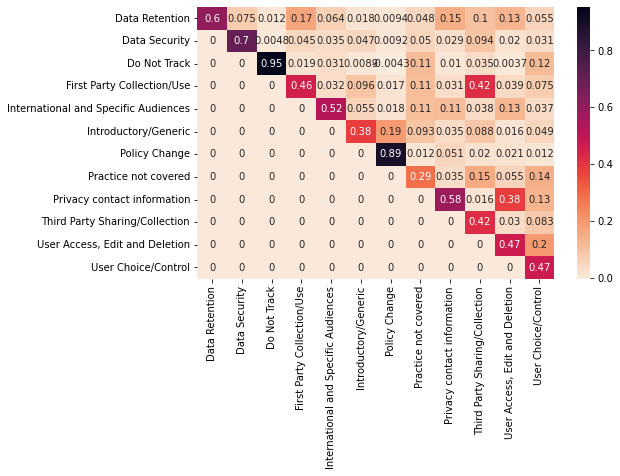

22974


C:\Users\IsmailKaraman\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3829 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3829 [00:00<?, ?it/s]

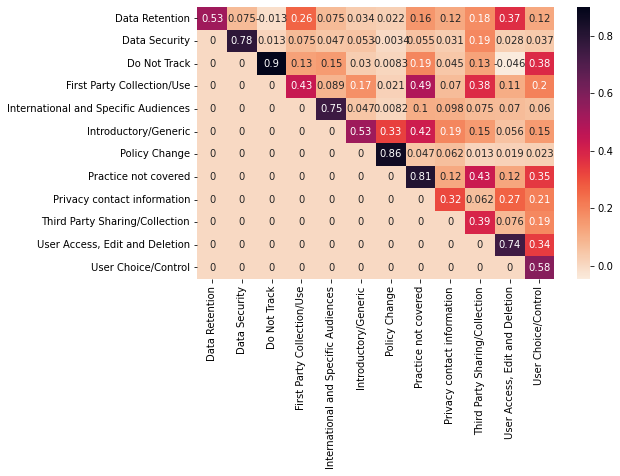

50130


C:\Users\IsmailKaraman\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/8355 [00:00<?, ?it/s]

Iteration:   0%|          | 0/8355 [00:00<?, ?it/s]

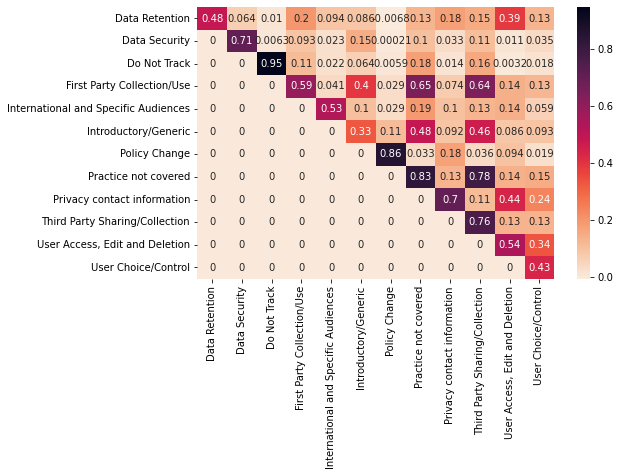

In [22]:
embedding_method = 'all-mpnet-base-v1'
X_num = utilities.vectorize_data(X, embedding_method)
sim_df = calculate_similarity_matrix(X_num, y)

i = 0

samples = False

for epoch_num in range(3):
    
    model = SentenceTransformer(embedding_method, device='cuda')
    
    if not samples:
        samples = create_initial_samples(y, 30, 50)
        print('initial samples are created!')
     
    train_set = create_train_data(X_num, X, y, samples)
    
    train_dataloader = DataLoader(train_set, shuffle=True, batch_size=6)
    train_loss = losses.CosineSimilarityLoss(model)
    model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=2, warmup_steps=50)
    
    X_num = vectorize_data(X, model)
    X_num = pd.Series([np.squeeze(i) for i in X_num])
    sim_df = calculate_similarity_matrix(X_num, y)
    
    plt.figure(i, figsize=(8,5)) 
    sns.heatmap(sim_df.fillna(0), annot=True,
                         xticklabels=sim_df.columns,
                         yticklabels=sim_df.columns, cmap="rocket_r")
    plt.show()
    i += 1
    
    samples = update_sample_sizes(sim_df, samples)

In [23]:
ss

NameError: name 'ss' is not defined

In [ ]:
embedding_method = 'all-mpnet-base-v1'
X_num = utilities.vectorize_data(X, embedding_method)
sim_df = calculate_similarity_matrix(X_num, y)
tuning_results.append(sim_df)

model = SentenceTransformer(embedding_method, device='cuda') 

i = 0
while True:
    
    samples = update_sample_sizes(sim_df, samples)
    train_set = create_train_data(X, y, samples)
    print(samples)
    train_dataloader = DataLoader(train_set, shuffle=True, batch_size=6)
    train_loss = losses.CosineSimilarityLoss(model)
    model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=5, warmup_steps=50)
    
    X_num = vectorize_data(X, model)
    X_num = pd.Series([np.squeeze(i) for i in X_num])
    sim_df = calculate_similarity_matrix(X_num, y)
    
    tuning_results.append((sim_df, model, X_num)) 
    
    plt.figure(i, figsize=(8,5)) 
    sns.heatmap(sim_df.fillna(0), annot=True,
                         xticklabels=sim_df.columns,
                         yticklabels=sim_df.columns, cmap="rocket_r")
    plt.show()
    i += 1
    with open(result_file_name, 'wb') as f:
        pickle.dump(tuning_results, f)
        
    if check_stopping(sim_df):
        break

In [ ]:
stop

In [ ]:
train_set

In [ ]:
X_num = vectorize_data(X, model)
X_num = pd.Series([np.squeeze(i) for i in X_num])
sim_df = calculate_similarity_matrix(X_num, y)

tuning_results.append((sim_df, model, X_num)) 

plt.figure(0, figsize=(8,5)) 
sns.heatmap(sim_df.fillna(0), annot=True,
                     xticklabels=sim_df.columns,
                     yticklabels=sim_df.columns, cmap="rocket_r")

In [ ]:
for embedding_method in iterate:
    
       
    train_set = create_train_data(X, y, sample_size=25)
    model = SentenceTransformer(embedding_method, device='cuda') 

    train_dataloader = DataLoader(train_set, shuffle=True, batch_size=6)
    train_loss = losses.CosineSimilarityLoss(model)

    model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=20, warmup_steps=50)

    X_num_tuned = vectorize_data(X, model)
    X_num_tuned = pd.Series([np.squeeze(i) for i in X_num_tuned])
    sim_df_after = calculate_similarity_matrix(X_num_tuned, y)
    
    tuning_results[embedding_method] = (sim_df_before, sim_df_after)
    
    with open(result_file_name, 'wb') as f:
        pickle.dump(tuning_results, f)

In [ ]:
stop

In [ ]:
with open(result_file_name, 'rb') as f:
    tuning_results = pickle.load(f)

In [ ]:
def scoring(sim_df):    
    scores = calculate_matrix_score(sim_df)[:-1]
    print(f'max: {max(scores):.2f}, min: {min(scores):.2f}, avg: {sum(scores)/len(scores):.2f}')

    l_sum = 100*np.diag(sim_df).sum()/12 - (sim_df.sum().sum()-np.diag(sim_df).sum())/66
    print(f'{l_sum:.2f}') 

In [ ]:
for k,v in tuning_results.items():
    print(k)
    print('before')
    scoring(v[0])
    print('after')
    scoring(v[1])
    
    # fig, axes = plt.subplots(1, 2, figsize=(16,5), squeeze=False)
    fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
    ax1, ax2 = axes
    sns.heatmap(v[0].fillna(0), annot=True,
                        xticklabels=v[0].columns,
                        yticklabels=v[0].columns, ax=ax1, cmap="rocket_r")
    sns.heatmap(v[1].fillna(0), annot=True,
                        xticklabels=v[1].columns,
                        yticklabels=v[1].columns, ax=ax2, cmap="rocket_r")

    plt.show()

    print('*'*70)

In [ ]:
embedding_method = 'all-mpnet-base-v1'
X_num = utilities.vectorize_data(X, embedding_method)

In [ ]:
while True:
    
    sim_df_before = calculate_similarity_matrix(X_num, y)
    
    
    train_set = create_train_data(X, y, sample_size=25)
    model = SentenceTransformer(embedding_method, device='cuda') 

    train_dataloader = DataLoader(train_set, shuffle=True, batch_size=6)
    train_loss = losses.CosineSimilarityLoss(model)

    model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=20, warmup_steps=50)

    X_num_tuned = vectorize_data(X, model)
    X_num_tuned = pd.Series([np.squeeze(i) for i in X_num_tuned])
    sim_df_after = calculate_similarity_matrix(X_num_tuned, y)
    
    tuning_results[embedding_method] = (sim_df_before, sim_df_after)
    
    with open(result_file_name, 'wb') as f:
        pickle.dump(tuning_results, f)

In [ ]:
df1 = tuning_results['all-mpnet-base-v1'][1]

In [ ]:
col1 - col1 > 0.5
col1 - col2 < 0.2

In [ ]:
total_samples = dict(y.sum())
total_samples

In [ ]:
for col1, col2 in combinations(df1.columns, 2):
    

In [ ]:
df1.columns

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(df1.fillna(0), annot=True,
                        xticklabels=df1.columns,
                        yticklabels=df1.columns, cmap="rocket_r")

In [ ]:
for k,v in tuning_results.items():
    print(k)
    print('before')
    scoring(v[0])
    print('after')
    scoring(v[1])

In [ ]:
df1 = tuning_results['stsb-roberta-large'][1]

In [ ]:
samples = {}
for col1, col2 in list(combinations(df1.columns, 2)):
    if df1.loc[col1, col2] > 0.2:
        samples[(col1, col2)] = 100

In [ ]:
samples

In [ ]:
y.sum()

In [ ]:
def scoring(simdf):    
    scores = calculate_matrix_score(sim_df)[:-1]
    print(f'{embedding} --- max: {max(scores):.2f}, min: {min(scores):.2f}, avg: {sum(scores)/len(scores):.2f}')

    l_sum = 100*np.diag(sim_df).sum()/12 - (sim_df.sum().sum()-np.diag(sim_df).sum())/66
    print(f'{l_sum:.2f}')  

In [ ]:
plt.figure(figsize=(7,5))

sns.heatmap(sim_df.fillna(0), annot=True,
xticklabels=sim_df.columns,
yticklabels=sim_df.columns, cmap="rocket_r")

plt.show()